Threat Intelligence with MISP Part 6 – Using the API

MISP - Malware Information Sharing Platform and Threat Sharing

In [128]:
# install pymisp in jupyter cell directly
# !pip3 install pymisp
import urllib3
from urllib3.exceptions import InsecureRequestWarning
# disable ssl warnings
urllib3.disable_warnings(InsecureRequestWarning)
# import PyMISP object from pymisp Python library
from pymisp import PyMISP
# define url or IP address of MISP instance
MISP_URL = 'http://localhost/'
# define MISP API key, generated from MISP instance, 'Authentication' -> 'List Auth Keys'
MISP_API_KEY = 'XRXFHOwNFiMQxu1bdgPL63ifWjvLTlH5cVdSv0M7'
# create MISP instance to interact with using Python methods
misp = PyMISP(MISP_URL, MISP_API_KEY, ssl=False, debug=False)

In [122]:
# to retrieve general statistics, we can use users_statistics() method associated with the misp object you created when authenticating.
# this returns a Python dictionary, which we can query for information like total users, events, and attributes.
from pprint import pprint
user_stats = misp.users_statistics()
#pprint(user_stats)

def general_stats():
    res = misp.users_statistics()
    print(f"Total users: {res['stats']['user_count']}")
    print(f"Total events: {res['stats']['event_count']}")
    print(f"Total attributes:{res['stats']['attribute_count']}")

general_stats()

Total users: 2
Total events: 7701
Total attributes:7813968


In [14]:
# to retrieve tag statistics, we can use the tag_statistics() method associated with the misp object created.
# this returns a Python dictionary which we can query for information based on specific tags.
tag_stats = misp.tags_statistics()
#pprint(tag_stats)

def tag_stats():
    res = misp.tags_statistics()
    print(f"Total reports: {res['tags']['cssa:origin=report']}")
    print(f"Total investigations: {res['tags']['cssa:origin=manual_investigation']}")
    print(f"Total purple team exercises: {res['tags']['custom:purple-team-exercise']}")

general_stats()

Total users: 2
Total events: 7291
Total attributes:5826570


In [15]:
# to retrieve attributes' statistics, we can use the attributes_statistics() method associated with the misp object created.
# this returns a Python dictionary, which we can query for information about specific attributes.
response = misp.attributes_statistics()
#pprint(response)
pprint(f"Total MD5 hashes: {response['md5']}")
pprint(f"Total domains: {response['domain']}")
pprint(f"Total IP addresses: {response['ip-dst']}")
pprint(f"Total urls: {response['url']}")
pprint(f"Total email addresses: {response['email-src']}")

def attribute_stats():
    res = misp.attributes_statistics()
    print(f"Total MD5 hashes: {res['md5']}")
    print(f"Total domains: {res['domains']}")
    print(f"Total IP addresses: {res['ip-dst']}")
    print(f"Total URLs: {res['url']}")
    print(f"Total email addresses: {res['email-src']}")
general_stats()

'Total MD5 hashes: 435483'
'Total domains: 748890'
'Total IP addresses: 1019692'
'Total urls: 487141'
'Total email addresses: 663'
Total users: 2
Total events: 7292
Total attributes:5829289


In [ ]:
# Below code searches for an IOC and uses the misp object's search_index() method to query the MISP API for this IOC.
# MISP will search all the attributes it has stored in its database and return the event an attribute is associated with.
# The Python code saves the response returned by the API in a dictionary data structure and checks to see if it contains data using an if statement.
# If it does, this data is parsed using dictionary bracket notation to return key event information that is printed using Python f-strings.
IOC = "oxcdntech.com"   # IOC can be any types.
response = misp.search_index(eventinfo=IOC)

if response:
    print("---- Matching Events ----")
    for event in response:
        print(f"Event ID: {event.get('id', 'N/A')}")        # use .get() method for safe dictionary access
        print(f"Event Info: {event.get('info', 'N/A')}")
        print(f"Date: {event.get('date', 'N/A')}")
        print(f"Threat Level ID: {event.get('threat_level_id')}")
        print(f"Analysis: {event.get('analysis')}")
        print("-" * 50)
else:
    print(f"No events found for {IOC}")
    print("Response:", response)

Processing 1000 events...
Processed 0 events...
Processed 100 events...
Processed 200 events...
Processed 300 events...
Processed 400 events...
Processed 500 events...
Processed 600 events...
Processed 700 events...
Processed 800 events...
Processed 900 events...
Finished processing 1000 events!

Found 9 TTPs with >9 occurrences:
  T1566.001: 17
  T1566: 17
  T1071.001: 15
  T1082: 14
  T1059.001: 13
  T1083: 12
  T1057: 10
  T1070.004: 10
  T1566.002: 10


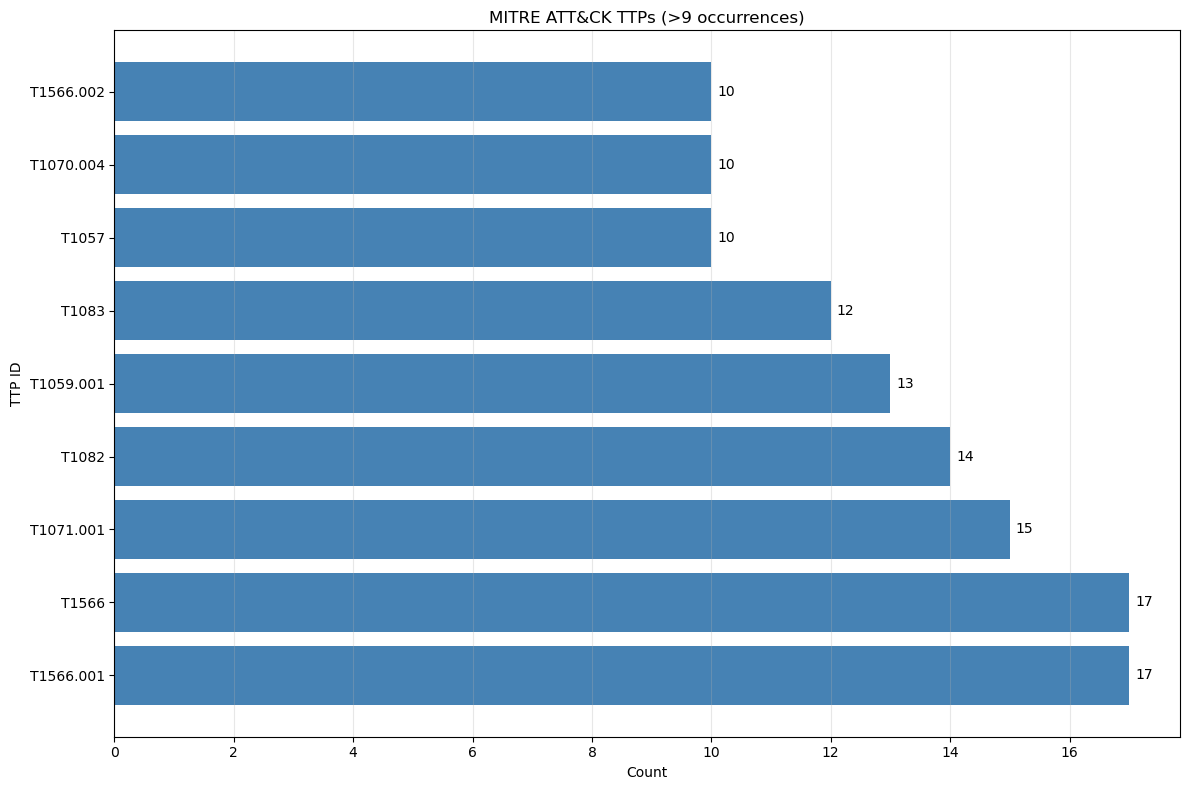

In [ ]:
# Get the top 10 mostly used TTPs by TAs from the MISP instance, and plot to a graph.
def simple_ttp_count(misp):
    ttps = {}
    events = misp.search_index(eventinfo=True, tags=["misp-galaxy:mitre-attack-pattern"], limit=1000)
    
    # Manually limit to first 1000 events
    events = events[:1000]
    
    print(f"Processing {len(events)} events...")
    
    for i, event in enumerate(events):
        if i % 100 == 0:  # Progress update every 100 events
            print(f"Processed {i} events...")
        
        # Stop at exactly 1000 events
        if i >= 1000:
            break
            
        full_event = misp.get_event(event['id'], extended=True)
        galaxies = full_event.get('Event', {}).get('Galaxy', [])
        
        for galaxy in galaxies:
            if galaxy.get('type') == 'mitre-attack-pattern':
                for cluster in galaxy.get('GalaxyCluster', []):
                    for ttp_id in cluster.get('meta', {}).get('external_id', []):
                        if ttp_id.startswith('T'):
                            ttps[ttp_id] = ttps.get(ttp_id, 0) + 1
    
    print(f"Finished processing {len(events)} events!")
    return ttps

def get_top10_ttps(misp):
    # Get all TTPs
    ttps = simple_ttp_count(misp)
    
    # Sort by count and get top 10
    top10 = sorted(ttps.items(), key=lambda x: x[1], reverse=True)[:10]
    
    print(f"\nFound {len(ttps)} unique TTPs total")
    print("\nTop 10 TTPs:")
    print("-" * 30)
    
    for i, (ttp, count) in enumerate(top10, 1):
        print(f"{i:2}. {ttp}: {count}")
    
    return top10

def plot_ttps_over_9(misp):
    import matplotlib.pyplot as plt
    
    # Get all TTPs
    ttps = simple_ttp_count(misp)
    
    # Filter TTPs with more than 9 occurrences
    frequent_ttps = {ttp: count for ttp, count in ttps.items() if count > 9}
    
    if not frequent_ttps:
        print("No TTPs found with more than 9 occurrences")
        return
    
    # Sort by count (descending)
    sorted_ttps = sorted(frequent_ttps.items(), key=lambda x: x[1], reverse=True)
    
    # Separate into lists for plotting
    ttp_names = [ttp for ttp, count in sorted_ttps]
    ttp_counts = [count for ttp, count in sorted_ttps]
    
    print(f"\nFound {len(frequent_ttps)} TTPs with >9 occurrences:")
    for ttp, count in sorted_ttps:
        print(f"  {ttp}: {count}")
    
    # Create horizontal bar chart
    plt.figure(figsize=(12, 8))
    plt.barh(ttp_names, ttp_counts, color='steelblue')
    plt.xlabel('Count')
    plt.ylabel('TTP ID')
    plt.title('MITRE ATT&CK TTPs (>9 occurrences)')
    plt.grid(axis='x', alpha=0.3)
    
    # Add count labels on bars
    for i, count in enumerate(ttp_counts):
        plt.text(count + 0.1, i, str(count), va='center')
    
    plt.tight_layout()
    plt.show()
    
    return frequent_ttps

# Usage:
# top10 = get_top10_ttps(misp)
frequent_ttps = plot_ttps_over_9(misp)

In [ ]:
# Use direct REST API call to get all the events in MISP instance.
import requests
import json

# Method 2: Direct REST API call (VERY FAST)
def fastest_ttp_count_rest(misp_url, auth_key):
    """Direct REST API call - bypasses PyMISP overhead"""
    ttps = {}
    
    headers = {
        'Authorization': auth_key,
        'Accept': 'application/json',
        'Content-Type': 'application/json'
    }
    
    # Direct API call
    url = f"{misp_url}/events/index"
    data = {
        'tags': ['misp-galaxy:mitre-attack-pattern'],
        'includeGalaxy': True,
        'limit': 1000
    }
    
    response = requests.post(url, headers=headers, json=data, verify=False)
    
    if response.status_code == 200:
        events = response.json()
        print(f"Direct REST: Got {len(events)} events!")
        
        for event_data in events:
            event = event_data.get('Event', {})
            galaxies = event.get('Galaxy', [])
            
            for galaxy in galaxies:
                if galaxy.get('type') == 'mitre-attack-pattern':
                    for cluster in galaxy.get('GalaxyCluster', []):
                        for ttp_id in cluster.get('meta', {}).get('external_id', []):
                            if ttp_id.startswith('T'):
                                ttps[ttp_id] = ttps.get(ttp_id, 0) + 1
    else:
        print(f"REST API failed: {response.status_code}")
    
    return ttps

ttps = fastest_ttp_count_rest(MISP_URL, MISP_API_KEY)

Direct REST: Got 7735 events!


In [ ]:
# Use direct REST API call to get all the events and try to get the top 10 TTPs using the same REST API method but got no results. Need to fine tune the TTPs counting part.
import requests
import matplotlib.pyplot as plt
from collections import defaultdict

def get_top10_ttps_rest(misp_url, auth_key):
    """Get top 10 TTPs using direct REST API and plot them"""
    
    headers = {
        'Authorization': auth_key,
        'Accept': 'application/json',
        'Content-Type': 'application/json'
    }
    
    # Direct API call (using the working approach)
    url = f"{misp_url}/events/index"
    data = {
        'tags': ['misp-galaxy:mitre-attack-pattern'],
        'includeGalaxy': True,
        'limit': 1000
    }
    
    print("Fetching events from MISP...")
    response = requests.post(url, headers=headers, json=data, verify=False)
    
    if response.status_code != 200:
        print(f"API call failed: {response.status_code}")
        return []
    
    events = response.json()
    print(f"Got {len(events)} events!")
    
    # Count TTPs
    ttps = defaultdict(int)
    
    for event_data in events:
        event = event_data.get('Event', {})
        galaxies = event.get('Galaxy', [])
        
        for galaxy in galaxies:
            if galaxy.get('type') == 'mitre-attack-pattern':
                for cluster in galaxy.get('GalaxyCluster', []):
                    external_ids = cluster.get('meta', {}).get('external_id', [])
                    for ttp_id in external_ids:
                        if ttp_id.startswith('T'):
                            ttps[ttp_id] += 1
    
    # Get top 10
    top10 = sorted(ttps.items(), key=lambda x: x[1], reverse=True)[:10]
    
    print(f"\nFound {len(ttps)} unique TTPs")
    print("Top 10 TTPs:")
    for i, (ttp, count) in enumerate(top10, 1):
        print(f"{i:2}. {ttp}: {count}")
    
    # Plot
    if top10:
        ttp_names = [ttp for ttp, count in top10]
        ttp_counts = [count for ttp, count in top10]
        
        plt.figure(figsize=(10, 6))
        plt.barh(ttp_names[::-1], ttp_counts[::-1], color='steelblue')
        plt.xlabel('Count')
        plt.ylabel('TTP ID')
        plt.title('Top 10 MITRE ATT&CK TTPs')
        plt.grid(axis='x', alpha=0.3)
        
        # Add count labels
        for i, count in enumerate(ttp_counts[::-1]):
            plt.text(count + 0.1, i, str(count), va='center')
        
        plt.tight_layout()
        plt.show()
    
    return top10

# Usage:
top10 = get_top10_ttps_rest(MISP_URL, MISP_API_KEY)

Fetching events from MISP...
Got 7740 events!

Found 0 unique TTPs
Top 10 TTPs:
